In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import spacy
import numpy as np
import pandas as pd
# import sklearn
import scipy as sp

import random
import math
import time

import progressbar as pb
import datetime
import os

import matplotlib.pyplot as plt

import pickle as pkl

In [2]:
SEED = 5050
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#### now let's build a loader for our data.

In [3]:
from aopy import datareader, datafilter
from torch.utils.data.sampler import SequentialSampler, BatchSampler, SubsetRandomSampler
from torch.utils.data import TensorDataset, random_split

In [4]:
# load data
data_file_full_path = '/Volumes/Samsung_T5/aoLab/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.dat'
data_in, data_param, data_mask = datareader.load_ecog_clfp_data(data_file_name=data_file_full_path)
srate_in= data_param['srate']
num_ch = data_param['num_ch']
# we already found the appropriate data masks, so just load them in
mask_file_path = "/Volumes/Samsung_T5/aoLab/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.mask.pkl"
with open(mask_file_path, 'rb') as f:
    mask_data = pkl.load(f)
hf_mask = mask_data["hf"]
sat_mask = mask_data["sat"]

Loading data file:


In [5]:
data_size = data_in.shape

In [6]:
# # plot data segment for a nice tidy figure
# import matplotlib.pyplot as pp
# t_plot = np.arange(data_in.shape[1])/srate_in
# t_plot.shape

# t_start = 70
# t_end = 80
# plot_idx = range(srate_in*t_start,srate_in*t_end)
# n_chan_plot = 10
# ch_idx = range(n_chan_plot)

# fig, ax = pp.subplots(figsize=(3,8))
# ax.plot(data_in[0:n_chan_plot*6:6,plot_idx].transpose() + 1500*np.arange(n_chan_plot),t_plot[plot_idx])
# ax.set_ylim((t_start,t_end))
# fig.patch.set_visible(False)
# ax.set_xlabel('ECoG Data')
# ax.axis('off')

# with open("ECoG_trace.png", 'wb') as outfile:
#     fig.canvas.print_png(outfile)
data_in.dtype

dtype('float32')

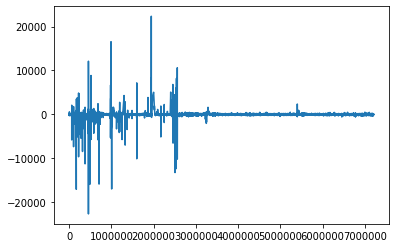

In [7]:
plot_ind = ~np.logical_or(hf_mask,sat_mask)
plt.plot(np.arange(data_in.shape[1])[plot_ind], data_in[-1,plot_ind])

In [8]:
# mask data array, remove obvious outliers
data_in[:,np.logical_or(hf_mask,sat_mask)] = 0.

In [9]:
# re(down)sample data
# srate = 250 # not much signal above 100Hz
# ds_factor = np.intc(np.floor(srate_in/srate)) # decimate does not allow for floats as ds_fac arguments
# data_in = sp.signal.decimate(data_in,ds_factor,axis=-1)

In [10]:
mask_file_path = "/Volumes/Samsung_T5/aoLab/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.mask.pkl"
with open(mask_file_path, 'rb') as f:
    data = pkl.load(f)
print(data)

{'hf': array([False, False, False, ..., False, False, False]), 'sat': array([False, False, False, ..., False, False, False])}


In [11]:
from torch.utils.data import Dataset, DataLoader

class EcogDataset(Dataset):
    def __init__(self, data_in, block_len):
        self.data = data_in
        self.block_len = int(block_len)
        self.data_len = self.data.shape[0]

    def __len__(self):
        return self.data.shape[0] // self.block_len

    def __getitem__(self, idx):
        # get data range (make sure not to sample from outside range)
        return self.data[idx:(idx + self.block_len),:]
        # an attempt at zero-padding to fix the tensor cat issue.
#         smpl = self.data[idx:(idx + self.block_len),:]
#         if smpl.shape[0] < self.block_len:
#             smpl_ = smpl
#             smpl = np.zeros((self.block_len,smpl_.shape[1]),dtype=np.float)
#             smpl[:smpl_.shape[0],:] = smpl_
#         return smpl

In [12]:
# create dataframe
srate = srate_in
# data_in = np.double(data_in[:,:120*srate])
enc_len = 10
dec_len = 1
seq_len = enc_len+dec_len # use ten time points to predict the next time point

unit_convert_uV_V = 1.e-6
# dataset = pd.DataFrame(data_in.transpose(),dtype=np.double) # may be unnecessary for now, but df will probably help combine files in the future.
# datareader.load_ecog_clfp_data.get_args()


In [14]:
data_tensor = torch.from_numpy(sp.stats.zscore(data_in[:,data_size[1]//2:].view().transpose()))
print(data_tensor.size)
dataset = EcogDataset(data_tensor,seq_len) ## make my own Dataset class

<built-in method size of Tensor object at 0x1aaaef7410>


In [19]:
train_frac = 0.8
valid_frac = 0.1
test_frac = 0.1
block_time = 20
block_size = block_time*srate
BATCH_SIZE = 1

data_size = np.shape(data_tensor)[0]
n_block = np.floor(data_size/block_size)
idx_all = np.arange(data_size)
smpl_idx_all = idx_all[:-seq_len:seq_len]
n_samp = len(smpl_idx_all)
shuffle_idx = torch.randperm(n_samp)
train_split = int(np.floor(train_frac*n_samp))
valid_split = int(np.floor(valid_frac*n_samp))
test_split = int(np.floor(test_frac*n_samp))
# rework this using
train_idx = smpl_idx_all[shuffle_idx[:train_split]]
valid_idx = smpl_idx_all[shuffle_idx[train_split:train_split+valid_split]]
test_idx = smpl_idx_all[shuffle_idx[train_split+valid_split:-1]]
print(train_idx.shape,valid_idx.shape,test_idx.shape)

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                           sampler=train_sampler,
                                           drop_last=True) # this can be avoided using some padding sequence classes, I think
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                           sampler=valid_sampler,
                                           drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                          sampler=test_sampler,
                                          drop_last=True)

(262078,) (32759,) (32760,)


In [20]:
# if your DataLoader is working correctly, this should be `torch.Size([<seq_len>, <num_ch>])
dataset.__getitem__(next(iter(train_sampler))).shape
# data_in.shape

torch.Size([11, 62])

#### back to our data (potenially)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
# BATCH_SIZE = 128
# train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
#     (train_data, valid_data, test_data),
#     batch_size = BATCH_SIZE,
#     device = device)

In [23]:
class Encoder_GRU(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        # gated recurrent layer, dropout layer
        self.rnn = nn.GRU(input_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        # note: batch_first only permutes dimension order in input and output tensors. It does not affect hidden state.
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_data):
        # input_data: [batch_size x seq_len x input_dim]
        # h0: [n_layers x batch_size x hid_dim]
        batch_size = input_data.size(0)
#         hidden = torch.randn(self.n_layers, batch_size, self.hid_dim) # initialize hidden layer value
        output, hidden = self.rnn(input_data) # hidden initialized as zero tensor
            
        # output = [batch_size x seq_len x hid_dim]
        # hidden = [n layers * n directions, batch size, hid dim]

        return output, hidden

In [24]:
class Decoder_GRU(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.rnn = nn.GRU(hid_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_data, hidden):
        # input = [batch_size, seq_len, hid_dim]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]
        
        # hidden = [n layers, batch size, hid dim]
        
#         input_data = input_data.unsqueeze(0) # not sure if this this is needed for not-embedded inputs
        if len(input_data.size()) != 3 or len(hidden.size()) != 3:
            breakpoint()
        output, hidden = self.rnn(input_data, hidden)
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #"seq len and n directions will always be 1 in the decoder, therefore:" <- figure out how to change this
        #output = [batch_size, 1, hid dim]
        #hidden = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output)
        
        return prediction, output, hidden # predicted ECoG signal, decoder states, last decoder state

In [25]:
class Seq2Seq_GRU(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device # what is this?
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Encoder, decoder embedding dimensions (hidden state) must be equal."
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder, decoder layer number must be equal."
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio: prob. to use teacher forcing
        #e.g. if 0.75, ground-truth imports are used 75% of the time
        
        batch_size = trg.shape[0]
        
        src_len = src.shape[1]
        src_dim = src.shape[2]
        
        trg_len = trg.shape[1]
        trg_dim = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, trg_dim).to(self.device)
        
        enc_state, hidden = self.encoder(src)
        
        output = src[:,-1,:].unsqueeze(1) # start the decoder with the actual output
        
        for t in range(trg_len): # ignore that first data point
            pred, output, hidden = self.decoder(output,hidden)
            
            outputs[:,t,:] = pred.squeeze()
            
            teacher_force = random.random() < teacher_forcing_ratio
            
            input = trg[:,t,:] if teacher_force else output
        
        return outputs

In [26]:
INPUT_SEQ_LEN = 10 
OUTPUT_SEQ_LEN = 1 # predict one output state from 10 inputs prior
INPUT_DIM = num_ch
OUTPUT_DIM = num_ch
HID_DIM = num_ch
N_ENC_LAYERS = 1 
N_DEC_LAYERS = 1
ENC_DROPOUT = np.float32(0.5)
DEC_DROPOUT = np.float32(0.5)

enc = Encoder_GRU(INPUT_DIM, HID_DIM, N_ENC_LAYERS, ENC_DROPOUT)
dec = Decoder_GRU(OUTPUT_DIM, HID_DIM, N_DEC_LAYERS, DEC_DROPOUT)

model = Seq2Seq_GRU(enc, dec, device).to(device)

/Users/mickey/anaconda3/envs/ecog_is2s/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [27]:
# # example of enc/dec function
# # let's pass the first pop off the dataset to the encoder and look at the outputs
# enc_out, hid_enc = enc.forward(test_loader.__iter__()._next_data())
# # out: [h1, h2, ..., h{seq_len}]
# # hid: h{seq_len}
# print(enc_out.size(),hid_enc.size())
# est, dec_out, hid_dec = dec.forward(enc_out,hid_enc)
# print(est,dec_out.size(),hid_dec.size())

In [28]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq_GRU(
  (encoder): Encoder_GRU(
    (rnn): GRU(62, 62, batch_first=True, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder_GRU(
    (rnn): GRU(62, 62, batch_first=True, dropout=0.5)
    (fc_out): Linear(in_features=62, out_features=62, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 50,778 trainable parameters


In [30]:
optimizer = optim.Adam(model.parameters())

In [31]:
# PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.MSELoss()

In [32]:
# test the forward pass
# get first data pull
# dataset.__getitem__(next(iter(train_sampler)))
data_batch = next(iter(train_loader))
src = data_batch[:,:enc_len,:]
trg = data_batch[:,enc_len:,:]
print(src.size(),trg.size())
test_out = model(src,trg)
print(test_out.size()) # it actually works!
criterion(test_out,trg)

torch.Size([1, 10, 62]) torch.Size([1, 1, 62])
torch.Size([1, 1, 62])


tensor(2.1765, grad_fn=<MseLossBackward>)

In [50]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    batch_loss = []
#     widgets = [pb.Percentage(), progressbar.Bar()]
#     bar = pb.ProgressBar(widgets=widgets).start()
    for i, batch in enumerate(iterator):
        if np.mod(i+1,1000) == 0:
            print(i,len(iterator))
        src = batch[:,:-1,:]
        trg = batch[:,-1,:].unsqueeze(1) # otherwise it would automatically cut this out.

        optimizer.zero_grad()

        output = model(src, trg)

        #trg = [batch size, trg len, output dim]
        #output = [batch size, trg len, output dim]

        output_dim = output.shape[-1]

#         output = output[1:].view(-1, output_dim)
#         trg = trg[1:].view(-1)

        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()
        batch_loss.append(loss.item())

#         bar.update(10*i/10000)

#         if i > 10000:
#             break
        
    return epoch_loss / len(iterator), np.array(batch_loss)

In [51]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    batch_loss = []
    
    with torch.no_grad():
#         widgets = [pb.Percentage(), progressbar.Bar()]
#         bar = pb.ProgressBar(widgets=widgets).start()
#         i = 0
        for i, batch in enumerate(iterator):

            if np.mod(i+1,1000)==0:
                print(i,len(iterator))
            src = batch[:,:-1,:]
            trg = batch[:,-1,:].unsqueeze(1)

            output = model(src, trg, 0.) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]

#             output = output[1:].view(-1, output_dim)
#             trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]
            loss = criterion(output, trg)

            epoch_loss += loss.item()
            batch_loss.append(loss.item())

#             bar.update(i/10000)

#             if i > 10000:
#                 break
#             i += 1
        
    return epoch_loss / len(iterator), np.array(batch_loss)

In [52]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [53]:
print(type(model.encoder.rnn.dropout))
# result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,
# --> 716          self.dropout, self.training, self.bidirectional, self.batch_first)

<class 'float'>


In [ ]:
N_EPOCHS = 50
CLIP = 1

best_test_loss = float('inf')

train_loss = np.zeros(N_EPOCHS)
train_batch_loss = []
test_loss = np.zeros(N_EPOCHS)
test_batch_loss = []


f = plt.figure()
ax = f.add_subplot(1,1,1)

for e_idx, epoch in enumerate(range(N_EPOCHS)):
    
    start_time = time.time()
    
    print('Training Network:')
    train_loss[e_idx], trbl_ = train(model, train_loader, optimizer, criterion, CLIP)
    train_batch_loss.append(trbl_)
    print('Testing Network:')
    test_loss[e_idx], tebl_ = evaluate(model, test_loader, criterion)
    test_batch_loss.append(tebl_)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if test_loss[e_idx] < best_test_loss:
        best_test_loss = test_loss[e_idx]
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss[e_idx]:.3g}')
    print(f'\t Val. Loss: {test_loss[e_idx]:.3g}')
    
    ax.plot(e_idx,train_loss[e_idx],'b.')
    ax.plot(e_idx,test_loss[e_idx],'r.')



Training Network:
999 262078
1999 262078
2999 262078
3999 262078
4999 262078
5999 262078
6999 262078
7999 262078
8999 262078
9999 262078
10999 262078
11999 262078
12999 262078
13999 262078
14999 262078
15999 262078
16999 262078
17999 262078
18999 262078
19999 262078
20999 262078
21999 262078
22999 262078
23999 262078
24999 262078
25999 262078
26999 262078
27999 262078
28999 262078
29999 262078
30999 262078
31999 262078
32999 262078
33999 262078
34999 262078
35999 262078
36999 262078
37999 262078
38999 262078
39999 262078
40999 262078
41999 262078
42999 262078
43999 262078
44999 262078
45999 262078
46999 262078
47999 262078
48999 262078
49999 262078
50999 262078
51999 262078
52999 262078
53999 262078
54999 262078
55999 262078
56999 262078
57999 262078
58999 262078
59999 262078
60999 262078
61999 262078
62999 262078
63999 262078
64999 262078
65999 262078
66999 262078
67999 262078
68999 262078
69999 262078
70999 262078
71999 262078
72999 262078
73999 262078
74999 262078
75999 262078
76999

In [ ]:
# model.load_state_dict(torch.load('tut1-model.pt'))

valid_loss = evaluate(model, valid_loader, criterion)

print(f'| Test Loss: {test_loss[-1]:.3g}')

In [ ]:
# save your model

# pack this as a method into the seq2seq class later!

model_save_dir = "/Volumes/Samsung_T5/aoLab/Data/models/pyt/seq2seq"
datetime_str = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
model_save_file_name = 'test_network_model_' + datetime_str + '.pt'
model_save_path = os.path.join(model_save_dir,model_save_file_name)
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
            'valid_loss': valid_loss
            },model_save_path)